# reaction-network (Demo Notebook): Networks

### Author: Matthew McDermott
Last Updated: 08/23/22

The code provided in this notebook is an updated walkthrough of the first example (YMnO3) in the accompanying manuscript (see citation below). The refactored `reaction-network` package contains similar code to what was released with the manuscript; however, many processes/functions are now separated into their own defined classes/methods. For a look at the previous demo notebook (which also contained some of the raw results that went into the manuscript), please check out the _archived_ folder.

**If you use this code or Python package in your work, please consider citing the following paper:**

McDermott, M. J., Dwaraknath, S. S., and Persson, K. A. (2021). A graph-based network for predicting chemical reaction pathways in solid-state materials synthesis. 
Nature Communications, 12(1). https://doi.org/10.1038/s41467-021-23339-x

### Imports

In [1]:
import logging 

from mp_api.client import MPRester
from pymatgen.core.composition import Element
from pymatgen.analysis.phase_diagram import PhaseDiagram, PDPlotter
from monty.serialization import loadfn

from rxn_network.costs.softplus import Softplus
from rxn_network.thermo.chempot_diagram import ChemicalPotentialDiagram
from rxn_network.core.composition import Composition
from pymatgen.core.composition import Composition, Element
from rxn_network.entries.entry_set import GibbsEntrySet
from rxn_network.network.network import ReactionNetwork
from rxn_network.entries.nist import NISTReferenceEntry
from rxn_network.reactions.computed import ComputedReaction
from rxn_network.reactions.reaction_set import ReactionSet
from rxn_network.reactions.open import OpenComputedReaction
from rxn_network.network.entry import NetworkEntry, NetworkEntryType
from rxn_network.network.visualize import plot_network_on_graphistry, plot_network
from rxn_network.pathways.solver import PathwaySolver
from rxn_network.enumerators.basic import BasicEnumerator, BasicOpenEnumerator
from rxn_network.enumerators.minimize import MinimizeGibbsEnumerator, MinimizeGrandPotentialEnumerator

#import graphistry

%load_ext autoreload
%autoreload 2

logging.info("Logging initialized")

/Users/mcdermott/opt/miniconda3/envs/rn_dev2/lib/python3.10/site-packages/pymatgen/analysis/phase_diagram.py:26: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


### Case Study: YMnO3 assisted metathesis

We will be using the assisted metathesis synthesis of YMnO3 as a case study for the reaction network code. This is the first example discussed in the original manuscript. The assisted metathesis reaction reported by Todd & Neilson (JACS, 2019) corresponds to a net reaction equation:

$$ Mn_2O_3 + 2 YCl_3 + 3Li_2CO_3 \to 2YMnO_3 + 6LiCl + 3CO_2 $$

In the paper, they report a reaction pathway involving the formation of intermediates LiMnO2 and YOCl. These react to form YMnO3 product and LiCl byproduct. (The CO2 is released when Li2CO3 reacts initially to form LiMnO2).

### Downloading and modifying entries

First, we acquire entries for phases in the Y-Mn-O-Li-Cl-C chemical system from the Materials Project (MP), a computed materials database containing calculations for over 130,000 materials.

In [2]:
# with MPRester() as mpr:  # insert your Materials Project API key here
#     entries = mpr.get_entries_in_chemsys("Y-Mn-O-C-Cl-Li")

In [3]:
# from monty.serialization import dumpfn
# dumpfn(entries, "entries.json.gz")

In [4]:
entries = loadfn("entries.json.gz")

The `GibbsEntrySet` class allows us to automatically converet `ComputedStructureEntry` objects downloaded from the MP database into `GibbsComputedEntry` objects, where DFT-calculated energies have been converted to machine learning (ML)-estimated equivalent values of the Gibbs free energies of formation, $\Delta G_f$ for all entries at the specified temperature. 

For more information, check out the citation in the documentation for `GibbsComputedEntry`.

In [5]:
temp = 900  # units: Kelvin
entry_set = GibbsEntrySet.from_entries(entries, temp)

The `GibbsEntrySet` class has many helpful functions, such as the following `filter_by_stability()` function, which automatically removes entries which are a specified energy per atom above the convex hull of stability:

In [6]:
entry_set = entry_set.filter_by_stability(0.00)
entry_set.entries_list

[GibbsComputedEntry | mp-569304 | C4 (C)
 Gibbs Energy (900 K) = 0.0000,
 GibbsComputedEntry | mp-1214283 | C40 Cl32 (C5Cl4)
 Gibbs Energy (900 K) = -2.6421,
 GibbsComputedEntry | mp-1214294 | C28 Cl32 (C7Cl8)
 Gibbs Energy (900 K) = -1.8837,
 NISTReferenceEntry | CO2
 Gibbs Energy (900 K) = -4.1016,
 GibbsComputedEntry | mp-1008394 | Cl4 (Cl2)
 Gibbs Energy (900 K) = 0.0000,
 GibbsComputedEntry | mp-1018134 | Li3 (Li)
 Gibbs Energy (900 K) = 0.0000,
 NISTReferenceEntry | Li2CO3
 Gibbs Energy (900 K) = -9.9542,
 GibbsComputedEntry | mp-760097 | Li8 Mn8 C8 O28 (Li2Mn2C2O7)
 Gibbs Energy (900 K) = -82.6655,
 GibbsComputedEntry | mp-758215 | Li8 Mn4 C4 O16 (Li2MnCO4)
 Gibbs Energy (900 K) = -53.0994,
 GibbsComputedEntry | mp-18988 | Li8 Mn4 O12 (Li2MnO3)
 Gibbs Energy (900 K) = -40.0030,
 NISTReferenceEntry | Li2O
 Gibbs Energy (900 K) = -4.9774,
 GibbsComputedEntry | mp-1180721 | Li4 C1 O4 (Li4CO4)
 Gibbs Energy (900 K) = -15.1456,
 GibbsComputedEntry | mp-530177 | Li10 Mn14 O32 (Li5Mn7O

In this case, we remove all entries which are unstable (above an energy cutoff of 10 meV/atom), which greatly reduces the combinatorial complexity of the system.

## Building the reaction network

The reaction network can be initialized by providing 3 arguments to the `ReactionNetwork` class:

1. **entries:** iterable of entry-like objects (e.g., `GibbsComputedEntry`)
2. **enumerators:** iterable of enumerators which will be called during the build of the network
3. **cost_function:** the function used to calculate the cost of each reaction edge 

We will use a BasicEnumerator (see the **Enumerators Demo Notebook** for more information on the type of enumerators available):

In [15]:
be = BasicEnumerator()

[autoreload of rxn_network.jobs.core failed: Traceback (most recent call last):
  File "/Users/mcdermott/opt/miniconda3/envs/rn_dev2/lib/python3.10/site-packages/IPython/extensions/autoreload.py", line 257, in check
    superreload(m, reload, self.old_objects)
  File "/Users/mcdermott/opt/miniconda3/envs/rn_dev2/lib/python3.10/site-packages/IPython/extensions/autoreload.py", line 455, in superreload
    module = reload(module)
  File "/Users/mcdermott/opt/miniconda3/envs/rn_dev2/lib/python3.10/importlib/__init__.py", line 169, in reload
    _bootstrap._exec(spec, module)
  File "<frozen importlib._bootstrap>", line 619, in _exec
  File "<frozen importlib._bootstrap_external>", line 883, in exec_module
  File "<frozen importlib._bootstrap>", line 241, in _call_with_frames_removed
  File "/Users/mcdermott/PycharmProjects/reaction-network/src/rxn_network/jobs/core.py", line 39, in <module>
    from rxn_network.reactions.utils import get_computed_rxn
ModuleNotFoundError: No module named 'r

In [11]:
rxns = be.enumerate(entry_set)

INFO:enumerator:Ray is not initialized. Checking for existing cluster...
INFO:enumerator:Could not identify existing Ray instance. Creating a new one...
2022-09-13 12:22:24,331	INFO worker.py:1509 -- Started a local Ray instance. View the dashboard at 127.0.0.1:8265 
INFO:enumerator:HOST: f0-18-98-44-ca-3a.dhcp.lbnl.us, {'object_store_memory': 2147483648.0, 'CPU': 12.0, 'memory': 12490425549.0, 'node:127.0.0.1': 1.0}
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 54/54 [00:10<00:00,  4.92it/s]


In [17]:
list(rxns.get_rxns())

[0.08333 YMn12 -> Mn + 0.08333 Y,
 Mn + 0.08333 Y -> 0.08333 YMn12,
 CO2 -> C + O2,
 C + O2 -> CO2,
 0.1429 C7Cl8 -> C + 0.5714 Cl2,
 C + 0.5714 Cl2 -> 0.1429 C7Cl8,
 0.7143 C7Cl8 -> C5Cl4 + 0.8571 Cl2,
 C5Cl4 + 0.8571 Cl2 -> 0.7143 C7Cl8,
 0.6667 C5Cl4 -> C + 0.3333 C7Cl8,
 C + 0.3333 C7Cl8 -> 0.6667 C5Cl4,
 0.2 C5Cl4 -> C + 0.4 Cl2,
 C + 0.4 Cl2 -> 0.2 C5Cl4,
 3 YClO -> Y2O3 + YCl3,
 Y2O3 + YCl3 -> 3 YClO,
 2 YClO + 0.5 O2 -> Y2O3 + Cl2,
 Y2O3 + Cl2 -> 2 YClO + 0.5 O2,
 YClO + Cl2 -> YCl3 + 0.5 O2,
 YCl3 + 0.5 O2 -> YClO + Cl2,
 2 YCl3 + 1.5 O2 -> Y2O3 + 3 Cl2,
 Y2O3 + 3 Cl2 -> 2 YCl3 + 1.5 O2,
 YCl3 -> Y + 1.5 Cl2,
 Y + 1.5 Cl2 -> YCl3,
 0.5 Y2O3 -> Y + 0.75 O2,
 Y + 0.75 O2 -> 0.5 Y2O3,
 LiCl -> Li + 0.5 Cl2,
 Li + 0.5 Cl2 -> LiCl,
 MnCl2 -> Mn + Cl2,
 Mn + Cl2 -> MnCl2,
 2 Li2O -> O2 + 4 Li,
 O2 + 4 Li -> 2 Li2O,
 LiC -> Li + C,
 Li + C -> LiC,
 1.091 LiC -> Li + 0.09091 LiC12,
 Li + 0.09091 LiC12 -> 1.091 LiC,
 LiC12 -> Li + 12 C,
 Li + 12 C -> LiC12,
 LiC12 -> LiC + 11 C,
 LiC +

The cost function is a monotonic function used to assign weights to edges in the network. In this case, we will use the softplus function, assigned a temperature scaling of $T=900$ K, and use the default arguments which automatically determine the softplus weighting based on the energy per atom of the reaction:

In [9]:
cf = Softplus(900)

Finally, we provide these as arguments to the `ReactionNetwork` initialization:

In [10]:
rn = ReactionNetwork(rxns, cf)

This simply initializes a `ReactionNetwork` object but does not build the network graph. To do so, we call the `.build()` function:

In [11]:
rn.build()

INFO:ReactionNetwork:Building graph from reactions...
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2182/2182 [00:01<00:00, 1537.78it/s]


In [14]:
list(rxns.get_rxns())

[0.08333 YMn12 -> Mn + 0.08333 Y,
 Mn + 0.08333 Y -> 0.08333 YMn12,
 CO2 -> C + O2,
 C + O2 -> CO2,
 0.1429 C7Cl8 -> C + 0.5714 Cl2,
 C + 0.5714 Cl2 -> 0.1429 C7Cl8,
 0.7143 C7Cl8 -> C5Cl4 + 0.8571 Cl2,
 C5Cl4 + 0.8571 Cl2 -> 0.7143 C7Cl8,
 0.6667 C5Cl4 -> C + 0.3333 C7Cl8,
 C + 0.3333 C7Cl8 -> 0.6667 C5Cl4,
 0.2 C5Cl4 -> C + 0.4 Cl2,
 C + 0.4 Cl2 -> 0.2 C5Cl4,
 3 YClO -> Y2O3 + YCl3,
 Y2O3 + YCl3 -> 3 YClO,
 2 YClO + 0.5 O2 -> Y2O3 + Cl2,
 Y2O3 + Cl2 -> 2 YClO + 0.5 O2,
 YClO + Cl2 -> YCl3 + 0.5 O2,
 YCl3 + 0.5 O2 -> YClO + Cl2,
 2 YCl3 + 1.5 O2 -> Y2O3 + 3 Cl2,
 Y2O3 + 3 Cl2 -> 2 YCl3 + 1.5 O2,
 YCl3 -> Y + 1.5 Cl2,
 Y + 1.5 Cl2 -> YCl3,
 0.5 Y2O3 -> Y + 0.75 O2,
 Y + 0.75 O2 -> 0.5 Y2O3,
 LiCl -> Li + 0.5 Cl2,
 Li + 0.5 Cl2 -> LiCl,
 MnCl2 -> Mn + Cl2,
 Mn + Cl2 -> MnCl2,
 2 Li2O -> O2 + 4 Li,
 O2 + 4 Li -> 2 Li2O,
 LiC -> Li + C,
 Li + C -> LiC,
 1.091 LiC -> Li + 0.09091 LiC12,
 Li + 0.09091 LiC12 -> 1.091 LiC,
 LiC12 -> Li + 12 C,
 Li + 12 C -> LiC12,
 LiC12 -> LiC + 11 C,
 LiC +

This should have completed within a few seconds. You'll notice that two things happened:

1. The enumerator(s) were run and a list of reactions was generated
2. The weighted graph object was built with these reactions and stored under the `graph` attribute of the reaction network object

We can access this graph object, which is a graph-tool object, by using the `graph` attribute:

In [12]:
rn.graph

<Graph object, directed, with 984 vertices and 2674 edges, 2 internal vertex properties, 3 internal edge properties, at 0x14ec51550>

In [21]:
from jobflow import SETTINGS
from monty.serialization import MontyDecoder

store = SETTINGS.JOB_STORE

# connect to the job store
store.connect()

In [36]:
store.additional_stores["rxns"].update([{"blob_uuid":"12ce1284-64eb-409d-ba7e-9448f0fe59fd", "rxns":open("test.gt.gz", mode="rb")}])

In [37]:
store.additional_stores["rxns"].query_one({"blob_uuid":"12ce1284-64eb-409d-ba7e-9448f0fe59fd"})["rxns"]

"<_io.BufferedReader name='test.gt.gz'>"

In [30]:
import graph_tool.all as gt

In [33]:
rn.graph.save("test.gt.gz")

In [35]:
open("test.gt.gz", mode="rb")

<_io.BufferedReader name='test.gt.gz'>

In [20]:
from monty.serialization import dumpfn
dumpfn(rn.graph, "test.json.gz")

TypeError: Object of type Graph is not JSON serializable

In [17]:
a = loadfn("test.json.gz")

In [19]:
a.graph

There are a couple provided ways to plot reaction networks. The first is to use the built in drawing features in graph-tool, which have been provided in a wrapper function.

In [13]:
#plot_network(rn.graph);

You'll notice that at this stage, the reaction network graph is a collection of "sub"-networks, i.e. a collection of smaller reaction networks for smaller chemical subsystems. This configuration will change once we set up for pathfinding in the next section.

The second way to plot graphs is to use graphistry, which requires setting up an account on Graphistry Hub: https://hub.graphistry.com/

In [14]:
#plot_network_on_graphistry(rn.graph)

### Solving for reaction pathways

To solve for reaction pathways, we must set precursor phases, as well as a target phase. This will automatically build all the required "zero-cost" edges which connect the different chemical subsystems. Please see the original manuscript for more detail with regards to how this works. In short, zero-cost edges are drawn between and product node to any reactant node that contains a subset of the set consisting of the {precursors + products} phases. 

In [15]:
rn.set_precursors(["Li2CO3", "Mn2O3", "YCl3"])

In [16]:
rn.set_target("YMnO3")

We can see how this changes the network by re-drawing it:

In [17]:
rn.graph

<Graph object, directed, with 986 vertices and 5265 edges, 2 internal vertex properties, 3 internal edge properties, at 0x14ec51550>

In [18]:
# plot_network(rn.graph);

You should now see that the chemical subsystems have come together -- this is due to the zero-cost edges that were just described. We can now perform pathfinding to extract reaction pathways.

To get reaction pathways, we simply call the `find_pathways()` method. This automatically handles finding pathways to multiple targets, by calling the internal shortest paths method. The _k_ parameter specifies the number of shortest paths to find to each target.

In [19]:
paths = rn.find_pathways(["YMnO3", "LiCl", "CO2"], k=5)

PATHS to YMnO3 

--------------------------------------- 

2 YCl3 + 9 Mn2O3 -> Y2Mn2O7 + 2 Mn8Cl3O10 (dG = -0.015 eV/atom) 
Y2Mn2O7 + Mn2O3 -> 2 YMnO3 + 2 MnO2 (dG = 0.005 eV/atom) 
Total Cost: 0.528 

2 YCl3 + 9 Mn2O3 -> Y2Mn2O7 + 2 Mn8Cl3O10 (dG = -0.015 eV/atom) 
2 Y2Mn2O7 -> O2 + 4 YMnO3 (dG = 0.038 eV/atom) 
Total Cost: 0.535 

YCl3 + 5 Mn2O3 -> YMn2O5 + Mn8Cl3O10 (dG = -0.025 eV/atom) 
YMn2O5 -> YMnO3 + MnO2 (dG = 0.048 eV/atom) 
Total Cost: 0.535 

Li2CO3 + 0.5 Mn2O3 -> LiMnCO4 + 0.5 Li2O (dG = 0.029 eV/atom) 
3 Li2O + 2 YCl3 -> Y2O3 + 6 LiCl (dG = -0.297 eV/atom) 
Y2O3 + Mn2O3 -> 2 YMnO3 (dG = -0.069 eV/atom) 
Total Cost: 0.724 

Li2CO3 + 0.5 Mn2O3 -> LiMnCO4 + 0.5 Li2O (dG = 0.029 eV/atom) 
Li2O + YCl3 -> YClO + 2 LiCl (dG = -0.273 eV/atom) 
Mn2O3 + 3 YClO -> YCl3 + 2 YMnO3 (dG = 0.0 eV/atom) 
Total Cost: 0.744 

PATHS to LiCl 

--------------------------------------- 

Li2CO3 + 0.5 Mn2O3 -> LiMnCO4 + 0.5 Li2O (dG = 0.029 eV/atom) 
3 Li2O + 2 YCl3 -> Y2O3 + 6 LiCl (dG = -0.297

The output of this method is a list of `BasicPathway` objects. Note that these objects contain a list of reactions and associated costs, but the actual pathway is typically not balanced:

In [20]:
example_path = paths[0]
print(example_path)

2 YCl3 + 9 Mn2O3 -> Y2Mn2O7 + 2 Mn8Cl3O10 (dG = -0.015 eV/atom) 
Y2Mn2O7 + Mn2O3 -> 2 YMnO3 + 2 MnO2 (dG = 0.005 eV/atom) 
Total Cost: 0.528


This means that the reactions you see above do not necessarily include all reactants, nor do they include form all desired products. They are simply a series of reactions extracted from the reaction network that maybe encountered as the system attempts to get from starter phases to target phases.

To actually get balanced reactions, we can use the `PathwaySolver` class. This class takes a set of entries, a list of `BasicPathway` objects, as well as a cost function, and can be used to solve for balanced pathways given a net reaction. First we initialize the class:

In [21]:
ps = PathwaySolver(rn.entries, paths, cf) # open_elem="O", chempot=0

To balance the pathways, we must provide a net reaction representing the total conversion of precursors to final products. This corresponds to the assisted metathesis reaction we defined in the beginning. We can automatically make this reaction by initializing a `ComputedReaction` object from the corresponding entries:

In [22]:
product_entries = []
for i in ["YMnO3","LiCl","CO2"]:
    product_entries.append(rn.entries.get_min_entry_by_formula(i))
    
net_rxn = ComputedReaction.balance(rn.precursors,product_entries)
net_rxn

1.5 Li2CO3 + 0.5 Mn2O3 + YCl3 -> YMnO3 + 3 LiCl + 1.5 CO2

Finally, we provide the net reaction to the `PathwaySolver` object. Note that the _intermediate_rxn_energy_cutoff_ helps to limit which intermediate reactions are considered (this can substantially decrease the combinatorial complexity), and the _filter_interdependent_ flag verifies that suggested pathways do not contain interdependent reactions (i.e. where both the reactants of reaction A depend on the products of the reaction B, and the reactants of reaction B depend on the products of reaction A).

**Note: Even though this step is compiled/parallelized using Numba, this is often the most time-intensive step in the reaction network analysis. Consider limiting the value of the maximum number of combos, as well as the value of the intermediate reaction energy cutoff.**

In [28]:
balanced_paths = ps.solve(net_rxn, max_num_combos=4, 
                          intermediate_rxn_energy_cutoff=0.0, 
                          use_minimize_enumerator=True,
                          filter_interdependent=True)

INFO:PathwaySolver:Net reaction: 1.5 Li2CO3 + 0.5 Mn2O3 + YCl3 -> YMnO3 + 3 LiCl + 1.5 CO2 

INFO:PathwaySolver:Identifying reactions between intermediates...
MinimizeGibbsEnumerator (Batch 1): 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 45/45 [00:00<00:00, 148.23it/s]
INFO:PathwaySolver:Found 165 intermediate reactions! 

PathwaySolver (Batch 1): 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 175/175 [02:14<00:00,  1.30it/s]


We can now print the suggested, balanced reaction pathways:

In [29]:
for idx, path in enumerate(balanced_paths):
    print(f"Path {idx+1}", "\n")
    print(path)
    print("\n")

Path 1 

Mn2O3 + Y2O3 -> 2 YMnO3 (dG = -0.069 eV/atom) 
2 Li2CO3 -> CO2 + Li4CO4 (dG = 0.055 eV/atom) 
0.25 Li4CO4 + 0.3333 YCl3 -> 0.25 CO2 + LiCl + 0.1667 Y2O3 (dG = -0.159 eV/atom) 
Average Cost: 0.241


Path 2 

Mn2O3 + Y2O3 -> 2 YMnO3 (dG = -0.069 eV/atom) 
2 Li2CO3 -> CO2 + Li4CO4 (dG = 0.055 eV/atom) 
0.5 Li2CO3 + 0.3333 YCl3 -> 0.5 CO2 + LiCl + 0.1667 Y2O3 (dG = -0.093 eV/atom) 
0.25 Li4CO4 + 0.3333 YCl3 -> 0.25 CO2 + LiCl + 0.1667 Y2O3 (dG = -0.159 eV/atom) 
Average Cost: 0.243


Path 3 

Li2CO3 + Mn2O3 -> CO2 + 2 LiMnO2 (dG = 0.009 eV/atom) 
2 Li2CO3 -> CO2 + Li4CO4 (dG = 0.055 eV/atom) 
LiMnO2 + YClO -> LiCl + YMnO3 (dG = -0.081 eV/atom) 
0.25 Li4CO4 + 0.5 YCl3 -> 0.25 CO2 + LiCl + 0.5 YClO (dG = -0.161 eV/atom) 
Average Cost: 0.245


Path 4 

Mn2O3 + Y2O3 -> 2 YMnO3 (dG = -0.069 eV/atom) 
0.5 Li2CO3 + 0.3333 YCl3 -> 0.5 CO2 + LiCl + 0.1667 Y2O3 (dG = -0.093 eV/atom) 
Average Cost: 0.245


Path 5 

2 Li2CO3 -> CO2 + Li4CO4 (dG = 0.055 eV/atom) 
LiMnO2 + YClO -> LiCl + YMnO3 

In [23]:
balanced_paths

[Li2O + 0.6667 YCl3 -> 2 LiCl + 0.3333 Y2O3 (dG = -0.297 eV/atom) 
 Mn2O3 + Y2O3 -> 2 YMnO3 (dG = -0.069 eV/atom) 
 Li2CO3 -> CO2 + Li2O (dG = 0.146 eV/atom) 
 Average Cost: 0.252,
 Li2O + YCl3 -> 2 LiCl + YClO (dG = -0.273 eV/atom) 
 Li2CO3 -> CO2 + Li2O (dG = 0.146 eV/atom) 
 Li2CO3 + Mn2O3 -> CO2 + 2 LiMnO2 (dG = 0.009 eV/atom) 
 LiMnO2 + YClO -> LiCl + YMnO3 (dG = -0.081 eV/atom) 
 Average Cost: 0.254,
 Li2O + YCl3 -> 2 LiCl + YClO (dG = -0.273 eV/atom) 
 Li2CO3 -> CO2 + Li2O (dG = 0.146 eV/atom) 
 2 Li2CO3 -> CO2 + Li4CO4 (dG = 0.055 eV/atom) 
 LiMnO2 + YClO -> LiCl + YMnO3 (dG = -0.081 eV/atom) 
 Li4CO4 + 2 Mn2O3 -> CO2 + 4 LiMnO2 (dG = -0.025 eV/atom) 
 Average Cost: 0.254,
 Li2O + YCl3 -> 2 LiCl + YClO (dG = -0.273 eV/atom) 
 Li2CO3 -> CO2 + Li2O (dG = 0.146 eV/atom) 
 Li2CO3 + Mn2O3 -> LiCO2 + LiMn2O4 (dG = 0.046 eV/atom) 
 LiMnO2 + YClO -> LiCl + YMnO3 (dG = -0.081 eV/atom) 
 LiCO2 + LiMn2O4 -> CO2 + 2 LiMnO2 (dG = -0.038 eV/atom) 
 Average Cost: 0.255,
 Li2O + 0.6667 YCl3 ->

In [24]:
from rxn_network.pathways.pathway_set import PathwaySet

In [25]:
path_set = PathwaySet.from_paths(balanced_paths)

In [26]:
path_set.get_paths()

[Li2O + 0.6667 YCl3 -> 2 LiCl + 0.3333 Y2O3 (dG = -0.297 eV/atom) 
 Mn2O3 + Y2O3 -> 2 YMnO3 (dG = -0.069 eV/atom) 
 Li2CO3 -> CO2 + Li2O (dG = 0.146 eV/atom) 
 Average Cost: 0.252,
 Li2O + YCl3 -> 2 LiCl + YClO (dG = -0.273 eV/atom) 
 Li2CO3 -> CO2 + Li2O (dG = 0.146 eV/atom) 
 Li2CO3 + Mn2O3 -> CO2 + 2 LiMnO2 (dG = 0.009 eV/atom) 
 LiMnO2 + YClO -> LiCl + YMnO3 (dG = -0.081 eV/atom) 
 Average Cost: 0.254,
 Li2O + YCl3 -> 2 LiCl + YClO (dG = -0.273 eV/atom) 
 Li2CO3 -> CO2 + Li2O (dG = 0.146 eV/atom) 
 2 Li2CO3 -> CO2 + Li4CO4 (dG = 0.055 eV/atom) 
 LiMnO2 + YClO -> LiCl + YMnO3 (dG = -0.081 eV/atom) 
 Li4CO4 + 2 Mn2O3 -> CO2 + 4 LiMnO2 (dG = -0.025 eV/atom) 
 Average Cost: 0.254,
 Li2O + YCl3 -> 2 LiCl + YClO (dG = -0.273 eV/atom) 
 Li2CO3 -> CO2 + Li2O (dG = 0.146 eV/atom) 
 Li2CO3 + Mn2O3 -> LiCO2 + LiMn2O4 (dG = 0.046 eV/atom) 
 LiMnO2 + YClO -> LiCl + YMnO3 (dG = -0.081 eV/atom) 
 LiCO2 + LiMn2O4 -> CO2 + 2 LiMnO2 (dG = -0.038 eV/atom) 
 Average Cost: 0.255,
 Li2O + 0.6667 YCl3 ->

We note that **Pathway 12 most closely matches the experimentally observed reaction pathway** (ordering subject to change in the future).

However, many of the pathways include hypothetical (never-before-synthesized) materials (e.g., Li3MnO3), so the top-ranked pathway does not necessarily match what is experimentally observed.

### Running networks with jobflow

The `NetworkFW` class allows you to easily run the reaction network construction and pathfinding analysis via fireworks. Simply create a network firework, add it to the LaunchPad, and launch it on your computing resource. See the documentation for more information about each of the parameters.

In [20]:
from rxn_network.flows.core import NetworkFlowMaker
from rxn_network.jobs.core import GetEntrySetMaker, NetworkMaker, PathwaySolverMaker
from jobflow.managers.local import run_locally

In [15]:
precursors=["YCl3", "Mn2O3", "Li2CO3"]
targets=["YMnO3", "LiCl", "CO2"]
k=5
temp = 650+273
cf = Softplus(temp, ["energy_per_atom"], [1.0])
get_entry_set_maker = GetEntrySetMaker(temperature=temp, e_above_hull=0.000)
network_maker = NetworkMaker(cost_function=cf, precursors=precursors, targets=targets, calculate_pathways=k)
solver_maker = PathwaySolverMaker(cost_function=cf, precursors=precursors, targets=targets)

In [18]:
flow = NetworkFlowMaker(get_entry_set_maker=get_entry_set_maker, 
                 network_maker=network_maker, solver_maker=solver_maker, open_elem="O", chempots=[0.0]).make(precursors=precursors, targets=targets)

<module 'matplotlib.pyplot' from '/Users/mcdermott/opt/miniconda3/envs/rn_dev2/lib/python3.10/site-packages/matplotlib/pyplot.py'>

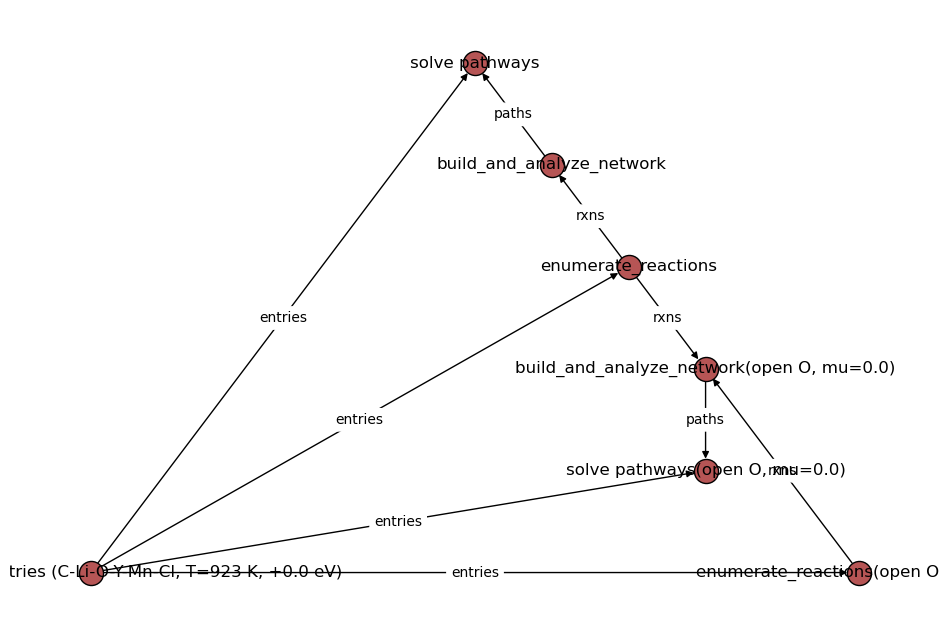

In [19]:
flow.draw_graph()

In [ ]:
run_locally(flow)

2022-09-13 22:56:51,480 INFO Started executing jobs locally


INFO:jobflow.managers.local:Started executing jobs locally


2022-09-13 22:56:51,483 INFO Starting job - get_and_process_entries (C-Li-O-Y-Mn-Cl, T=923 K, +0.0 eV) (d3a92a57-7ef1-4e3d-bada-a6799b7e5d7a)


INFO:jobflow.core.job:Starting job - get_and_process_entries (C-Li-O-Y-Mn-Cl, T=923 K, +0.0 eV) (d3a92a57-7ef1-4e3d-bada-a6799b7e5d7a)


2022-09-13 22:57:02,747 INFO Finished job - get_and_process_entries (C-Li-O-Y-Mn-Cl, T=923 K, +0.0 eV) (d3a92a57-7ef1-4e3d-bada-a6799b7e5d7a)


INFO:jobflow.core.job:Finished job - get_and_process_entries (C-Li-O-Y-Mn-Cl, T=923 K, +0.0 eV) (d3a92a57-7ef1-4e3d-bada-a6799b7e5d7a)


2022-09-13 22:57:02,750 INFO Starting job - enumerate_reactions (eb8abb5a-e3dd-4af7-ad7d-d596b7917312)


INFO:jobflow.core.job:Starting job - enumerate_reactions (eb8abb5a-e3dd-4af7-ad7d-d596b7917312)
INFO:enumerator:Ray is not initialized. Checking for existing cluster...
INFO:enumerator:Could not identify existing Ray instance. Creating a new one...
2022-09-13 22:57:05,764	INFO worker.py:1509 -- Started a local Ray instance. View the dashboard at 127.0.0.1:8265 
INFO:enumerator:HOST: macbook-pro-4.lan.vpn-dhcp.lbl.gov, {'object_store_memory': 2147483648.0, 'node:127.0.0.1': 1.0, 'memory': 13429948826.0, 'CPU': 12.0}
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 57/57 [00:03<00:00, 16.52it/s]


2022-09-13 22:57:41,866 INFO Finished job - enumerate_reactions (eb8abb5a-e3dd-4af7-ad7d-d596b7917312)


INFO:jobflow.core.job:Finished job - enumerate_reactions (eb8abb5a-e3dd-4af7-ad7d-d596b7917312)


2022-09-13 22:57:41,870 INFO Starting job - enumerate_reactions(open O, mu=0.0) (af1adb1c-4cfc-4f79-b759-b914b8503dc9)


INFO:jobflow.core.job:Starting job - enumerate_reactions(open O, mu=0.0) (af1adb1c-4cfc-4f79-b759-b914b8503dc9)
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 31/31 [00:02<00:00, 15.37it/s]


2022-09-13 22:57:45,045 INFO Finished job - enumerate_reactions(open O, mu=0.0) (af1adb1c-4cfc-4f79-b759-b914b8503dc9)


INFO:jobflow.core.job:Finished job - enumerate_reactions(open O, mu=0.0) (af1adb1c-4cfc-4f79-b759-b914b8503dc9)


2022-09-13 22:57:45,047 INFO Starting job - build_and_analyze_network (a21f9866-5f29-40fa-87ac-42b207babba4)


INFO:jobflow.core.job:Starting job - build_and_analyze_network (a21f9866-5f29-40fa-87ac-42b207babba4)
INFO:ReactionNetwork:Building graph from reactions...
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9873/9873 [00:12<00:00, 817.46it/s]


In [ ]:
lpad = LaunchPad.auto_load()

In [ ]:
fw = NetworkFW([BasicEnumerator()], Softplus(900), chemsys="Y-Mn-O-Li-Cl-C", entry_set_params={"e_above_hull":0.000}, 
               pathway_params={"precursors":["YCl3","Mn2O3","Li2CO3"], "targets":["YMnO3","LiCl","CO2"], "k":5},
              solver_params={"max_num_combos":4, "intermediate_rxn_energy_cutoff":0.0, "use_minimize_enumerator": True})

In [ ]:
lpad.add_wf(Workflow([fw]))

In [ ]:
!rlaunch singleshot

### Thank you!

If any errors with the reaction-network code are encountered, please raise an Issue here: https://github.com/GENESIS-EFRC/reaction-network/issues

In [ ]:
from maggma.stores import MongoStore
from rxn_network.pathways.pathway_set import PathwaySet

In [ ]:
ms = MongoStore.from_db_file("/Users/mcdermott/db_rn.json")
ms.connect()

In [ ]:
d = ms.query_one({"task_id":82}, ["balanced_pathways"])

In [ ]:
pset = PathwaySet.from_dict(d["balanced_pathways"])